In [1]:
import os
import re
import cv2
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import Delaunay
from tqdm import tqdm

In [2]:
if not os.path.exists("assets") or not os.path.isdir("assets"):
    os.mkdir("assets")
    os.mkdir("assets/pack_1")

if not os.path.exists("images") or not os.path.isdir("images"):
    os.mkdir("images")

In [3]:
def sorting_function(el):
    el = re.split("[._]", el)
    return int(el[1]), int(el[2])


current_directory = "assets/pack_1/"
contents = sorted(os.listdir(current_directory), key=sorting_function)

In [4]:
df = pd.DataFrame([], columns=[
    "person_id",
    "image",
    "fractal_dimension_boxes",
    "fractal_dimension_cubes",
    "fractal_dimension_triangulation",
])

load_from_cache = True
show_graphic_analysis = True

In [5]:
def count_nontrivial_boxes(binary_img: np.ndarray, box_size: int) -> int:
    """
    Считает количество квадратов размера box_size × box_size,
    которые частично содержат объект (не пусты и не полностью заполнены - особенность фрагментированной структуры).
    """
    height, width = binary_img.shape
    count = 0

    for y in range(0, height, box_size):
        for x in range(0, width, box_size):
            box = binary_img[y:y + box_size, x:x + box_size]
            filled = np.sum(box)
            if 0 < filled < box_size * box_size:
                count += 1
    return count


def fractal_dimension_boxes(image: np.ndarray, threshold: float = 0.9) -> float:
    """
    Вычисляет фрактальную размерность бинарного изображения с использованием box-counting метода.

    Описание:
    Метод квадратов основан на разбиении изображения на квадратные участки (клетки).
    Для каждого квадрата вычисляется его плотность, то есть количество клеток,
    которые содержат объект (не пусты). Затем рассчитывается фрактальная размерность
    путем нахождения зависимости между размером квадрата и количеством покрытых
    клеток. Это делается для разных размеров клеток и определяется, как эта зависимость
    изменяется при уменьшении размера квадратов.

    Параметры:
    - image: 2D-массив (изображение), значения от 0 до 1.
    - threshold: Порог для бинаризации. Всё, что меньше — считается частью объекта.

    Возвращает:
    - Фрактальную размерность (вещественное число).
    """
    # Бинаризация изображения
    binary_image = image < threshold  # True (1) — объект, False (0) — фон

    # Определение максимально возможного размера квадрата (степень двойки)
    min_side = min(binary_image.shape)
    max_power = int(np.floor(np.log2(min_side)))  # максимальная степень двойки
    box_sizes = 2 ** np.arange(max_power, 1, -1)  # например: [64, 32, 16, 8, 4]

    # Считаем N(box_size) для каждого размера
    box_counts = [count_nontrivial_boxes(binary_image, size) for size in box_sizes]

    # Вычисляем логарифмы для линейной регрессии
    log_sizes = np.log(box_sizes)
    log_counts = np.log(box_counts)

    # Линейная регрессия: log(N) = -D * log(size) + C
    slope, intercept = np.polyfit(log_sizes, log_counts, 1)
    fractal_dim = -slope

    return fractal_dim


def count_nontrivial_cubes(image: np.ndarray, cube_size: int) -> int:
    """
    Считает количество кубов размера cube_size³, которые пересекают поверхность изображения.
    Поверхность задаётся уровнем серого (ось Z).

    Математически: для каждого куба (i,j,k) проверяем, пересекает ли куб поверхность изображения.
    Куб пересекает поверхность, если в его проекции на плоскость XY есть пиксели как выше,
    так и ниже его Z-координаты.
    """
    height, width = image.shape
    count = 0

    # Итерация по сетке кубов в плоскости XY
    for y in range(0, height, cube_size):
        for x in range(0, width, cube_size):
            # Вырезаем прямоугольный фрагмент изображения размером cube_size × cube_size
            patch = image[y:y + cube_size, x:x + cube_size]
            if patch.size == 0:
                continue

            # Находим минимальную и максимальную яркость в текущем фрагменте
            # Эти значения определяют диапазон высот в этом фрагменте
            local_min = np.min(patch)
            local_max = np.max(patch)

            # Определяем, сколько кубов по оси Z пересекают этот фрагмент
            # z_start - индекс самого нижнего куба, пересекающего поверхность
            # z_end - индекс куба, следующего за самым верхним пересекающим поверхность
            # Целочисленное деление // для нижней границы гарантирует, что мы берем полный куб
            z_start = int(local_min // cube_size)

            # np.ceil и деление / для верхней границы гарантирует, что мы включаем весь верхний куб,
            # который может лишь частично содержать поверхность
            z_end = int(np.ceil(local_max / cube_size))

            # Добавляем к общему счету количество кубов, пересекающих поверхность в этой XY-позиции
            # Математически это равно количеству различных значений Z-координат кубов,
            # которые пересекают поверхность в данной проекции на плоскость XY
            count += (z_end - z_start)

    return count


def fractal_dimension_cubes(image: np.ndarray) -> float:
    """
    Вычисляет фрактальную размерность изображения с использованием 3D box-counting метода.

    Описание:
    Метод кубов — это аналог метода квадратов, но в трех измерениях. Изображение разбивается
    на кубические блоки размера cube_size x cube_size x cube_size. Затем для каждого куба
    вычисляется, содержится ли в нем объект, т.е. он не пуст и не полностью заполнен.
    Фрактальная размерность вычисляется путем нахождения зависимости между размером куба
    и количеством кубов, которые частично содержат объект. Как и в методе квадратов,
    исследуется, как изменяется количество этих кубов при уменьшении их размера,
    чтобы определить фрактальную размерность.

    где:
    - ε - размер куба
    - N(ε) - количество кубов размера ε, пересекающих поверхность
    - На практике вычисляется как угол наклона прямой в логарифмических координатах

    Параметры:
    - image: 2D-массив uint8, значения от 0 до 255 (градации серого).

    Возвращает:
    - Фрактальную размерность (от 2 до 3).
    """
    # Определяем минимальный размер стороны изображения
    min_side = min(image.shape)

    # Вычисляем максимальную степень двойки, которая не превышает минимальный размер стороны
    # Это определяет максимальный размер куба, который мы можем использовать
    max_power = int(np.floor(np.log2(min_side)))

    # Создаем набор размеров кубов, уменьшающихся в геометрической прогрессии
    # Использование степеней двойки обеспечивает равномерное распределение точек в лог-лог графике
    cube_sizes = 2 ** np.arange(max_power, 1, -1)  # [64, 32, 16, ...]

    # Для каждого размера куба вычисляем количество кубов, пересекающих поверхность
    cube_counts = [count_nontrivial_cubes(image, size) for size in cube_sizes]

    # Переходим к логарифмическим координатам для линейной аппроксимации
    log_sizes = np.log(cube_sizes)
    log_counts = np.log(cube_counts)

    # Применяем линейную регрессию для нахождения наклона прямой
    # В логарифмических координатах зависимость должна быть линейной:
    # log(N(ε)) = -D * log(ε) + C, где D - искомая фрактальная размерность
    slope, intercept = np.polyfit(log_sizes, log_counts, 1)

    # Фрактальная размерность равна модулю наклона этой прямой
    # Минус перед slope из-за того, что при уменьшении размера куба (ε)
    # количество кубов (N(ε)) увеличивается, т.е. наклон в координатах (log(ε), log(N(ε)))
    # отрицательный, а фрактальная размерность по определению положительна
    fractal_dim = -slope

    return fractal_dim


def triangle_area_3d(p1: np.ndarray, p2: np.ndarray, p3: np.ndarray) -> float:
    """
    Вычисляет площадь треугольника в 3D-пространстве используя векторное произведение.

    Параметры:
    - p1, p2, p3: координаты вершин треугольника в формате [x, y, z]

    Возвращает:
    - Площадь треугольника
    """
    # Векторы сторон треугольника
    v1 = p2 - p1
    v2 = p3 - p1

    # Векторное произведение даёт вектор, перпендикулярный плоскости треугольника
    # Его модуль равен удвоенной площади треугольника
    cross_product = np.cross(v1, v2)
    area = 0.5 * np.linalg.norm(cross_product)

    return max(area, 1e-10)  # Избегаем нулевых значений


def fractal_dimension_triangulation(image: np.ndarray) -> float:
    """
    Вычисляет фрактальную размерность изображения с использованием метода триангуляции Делоне.

    Описание:
    Метод использует триангуляцию Делоне для построения трехмерной поверхности,
    где x,y - координаты пикселей, а z - их интенсивность. Триангуляция выполняется
    по x,y координатам, но площади треугольников вычисляются с учетом z-координаты.
    Фрактальная размерность определяется по зависимости между масштабом выборки точек
    и суммарной площадью построенной поверхности.

    Параметры:
    - image: 2D-массив (изображение), значения от 0 до 255.

    Возвращает:
    - Фрактальную размерность (вещественное число в интервале [2, 3]).
    """
    height, width = image.shape

    # Создаем разные масштабы для анализа
    scales = [2, 4, 8, 16, 32]
    log_scales = np.log(scales)
    log_areas = []

    for scale in scales:
        try:
            # Выбираем точки из изображения с шагом scale
            y_coords, x_coords = np.mgrid[0:height:scale, 0:width:scale]
            points_2d = np.c_[x_coords.flatten(), y_coords.flatten()]

            # Проверяем, что у нас достаточно точек для триангуляции
            if len(points_2d) < 4:
                continue

            # Создаем 3D точки, добавляя интенсивность как z-координату
            z_coords = np.array([image[y, x] for y, x in zip(y_coords.flatten(), x_coords.flatten())])
            points_3d = np.c_[points_2d, z_coords]

            # Строим триангуляцию Делоне в 2D (по x и y координатам)
            tri = Delaunay(points_2d)

            # Вычисляем общую площадь поверхности в 3D
            total_area = 0
            for simplex in tri.simplices:
                # Берем 3D координаты точек для каждого треугольника
                p1 = points_3d[simplex[0]]
                p2 = points_3d[simplex[1]]
                p3 = points_3d[simplex[2]]

                # Вычисляем площадь треугольника в 3D пространстве
                area = triangle_area_3d(p1, p2, p3)
                total_area += area

            if total_area > 0:
                log_areas.append(np.log(total_area))
        except Exception as e:
            continue

    # Если не удалось построить триангуляцию или получить валидные площади
    if len(log_areas) < 2:
        return 2.0

    # Линейная регрессия для определения фрактальной размерности
    # log(Area) = (2-D) * log(Scale) + C
    # Для гладкой поверхности D = 2, для крайне неровной D → 3
    slope, intercept = np.polyfit(log_scales[:len(log_areas)], log_areas, 1)
    fractal_dim = 2 - slope

    # Убеждаемся, что результат в диапазоне [2, 3]
    return max(2.0, min(3.0, fractal_dim))

In [6]:
file_path = "assets/fractal_3_methods.csv"
if os.path.exists(file_path) and load_from_cache:
    df = pd.read_csv(file_path, encoding="utf8")

    # Загружаем изображение и преобразуем к uint8 (оттенки серого 0–255)
    image = plt.imread(current_directory + "/" + "finger_17_4.png")  # df.iloc[-1]["image"]
    image = np.array(image * 255, dtype=np.uint8)
    # Гауссовское размытие
    blurred = cv2.GaussianBlur(image, (1, 1), 0)
    binarized = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 21
    ) / 255
else:
    for img in tqdm(contents):
        person_id = img.split("_")[1]

        image = plt.imread(current_directory + img)
        image = np.array(image * 255, dtype=np.uint8)
        # Копии для разных методов
        blurred = cv2.GaussianBlur(image, (1, 1), 0)
        binarized = cv2.adaptiveThreshold(
            blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 21
        ) / 255

        # Вычисляем фрактальные размерности с помощью трёх различных методов
        fractal_boxes = fractal_dimension_boxes(binarized, threshold=0.25)
        fractal_cubes = fractal_dimension_cubes(image)
        fractal_tri = fractal_dimension_triangulation(image)

        df.loc[len(df.index)] = [person_id, img, fractal_boxes, fractal_cubes, fractal_tri]

    df.to_csv("assets/fractal_3_methods.csv", index=False)

df

,person_id,image,fractal_dimension_boxes,fractal_dimension_cubes,fractal_dimension_triangulation
0,1,finger_1_1.png,1.732474,2.497415,2.707327
1,1,finger_1_2.png,1.687689,2.482958,2.772233
2,1,finger_1_3.png,1.712783,2.497602,2.769660
3,1,finger_1_4.png,1.599063,2.506279,2.823779
4,1,finger_1_5.png,1.603144,2.504538,2.767796
...,...,...,...,...,...
260,51,finger_51_1.png,1.649993,2.564197,2.809512
261,51,finger_51_2.png,1.575441,2.484261,2.801734
262,51,finger_51_3.png,1.684498,2.594108,2.831591
263,51,finger_51_4.png,1.679051,2.585397,2.851601



=== Анализ фрактальной размерности изображения ===



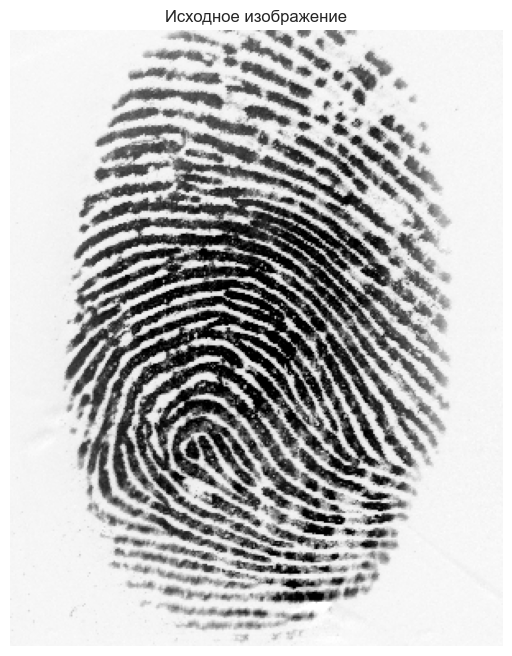


1. Метод квадратов (Box counting)
Фрактальная размерность (метод квадратов): 1.6821378382208516


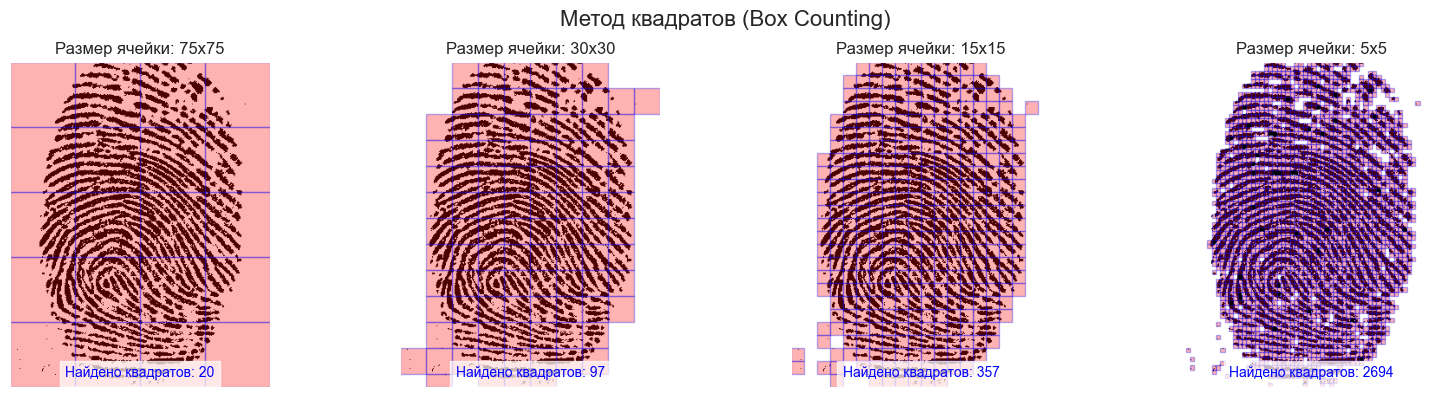

Размер ячейки: 256×256, Количество непустых ячеек: 4
Размер ячейки: 128×128, Количество непустых ячеек: 9
Размер ячейки: 64×64, Количество непустых ячеек: 29
Размер ячейки: 32×32, Количество непустых ячеек: 90
Размер ячейки: 16×16, Количество непустых ячеек: 319
Размер ячейки: 8×8, Количество непустых ячеек: 1176
Размер ячейки: 4×4, Количество непустых ячеек: 3718


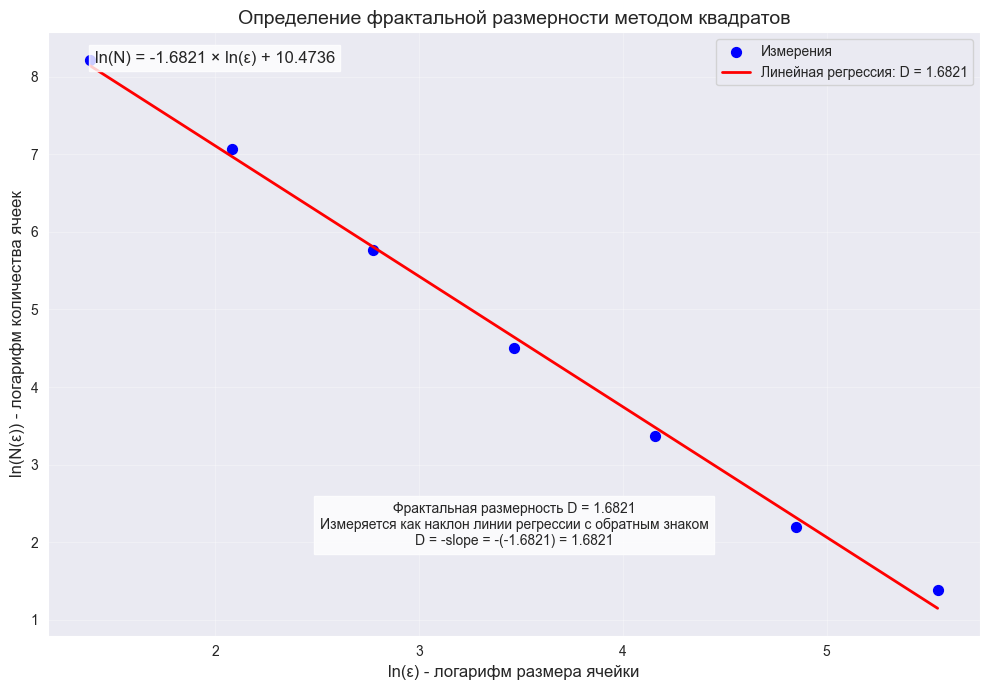


2. Метод кубов (3D Box counting)
Фрактальная размерность (метод кубов): 2.6129427593181056


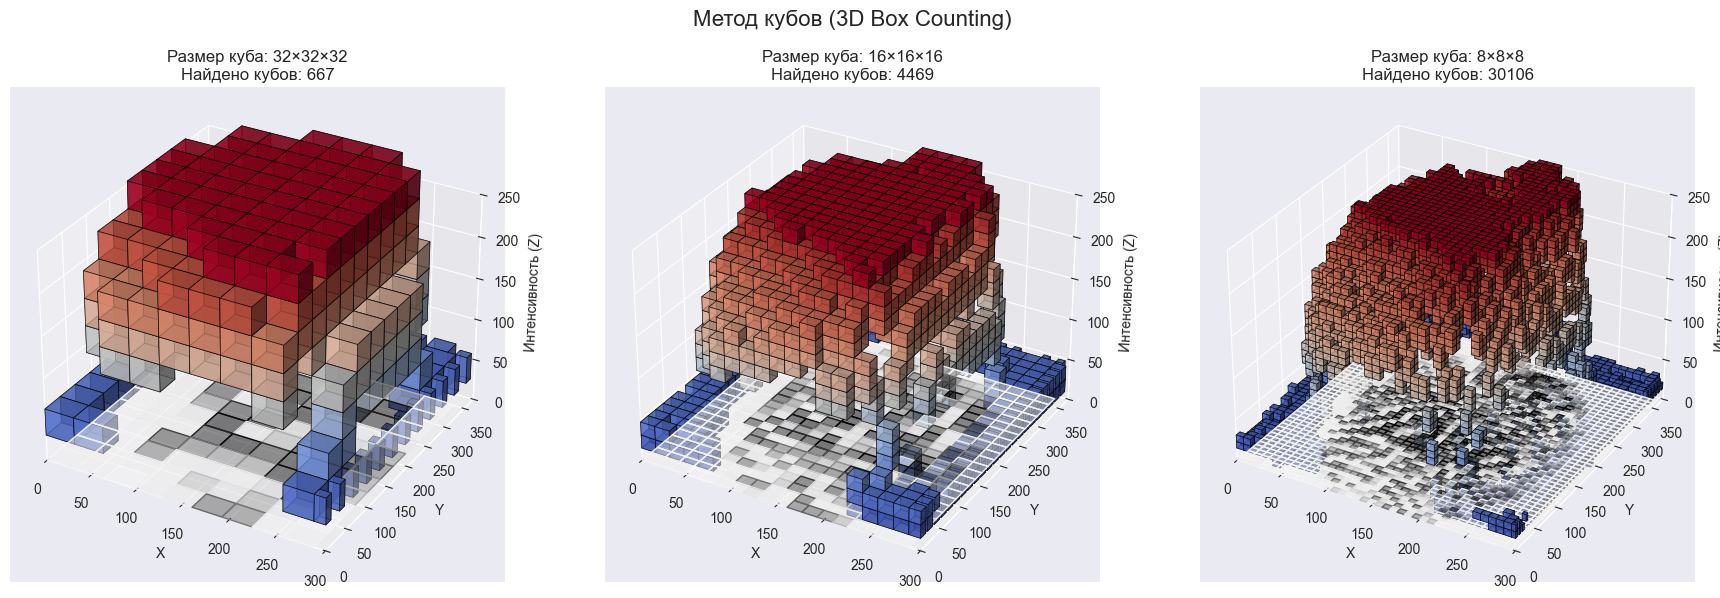


3. Метод триангуляции Делоне
Фрактальная размерность (метод триангуляции): 2.7949845132502156


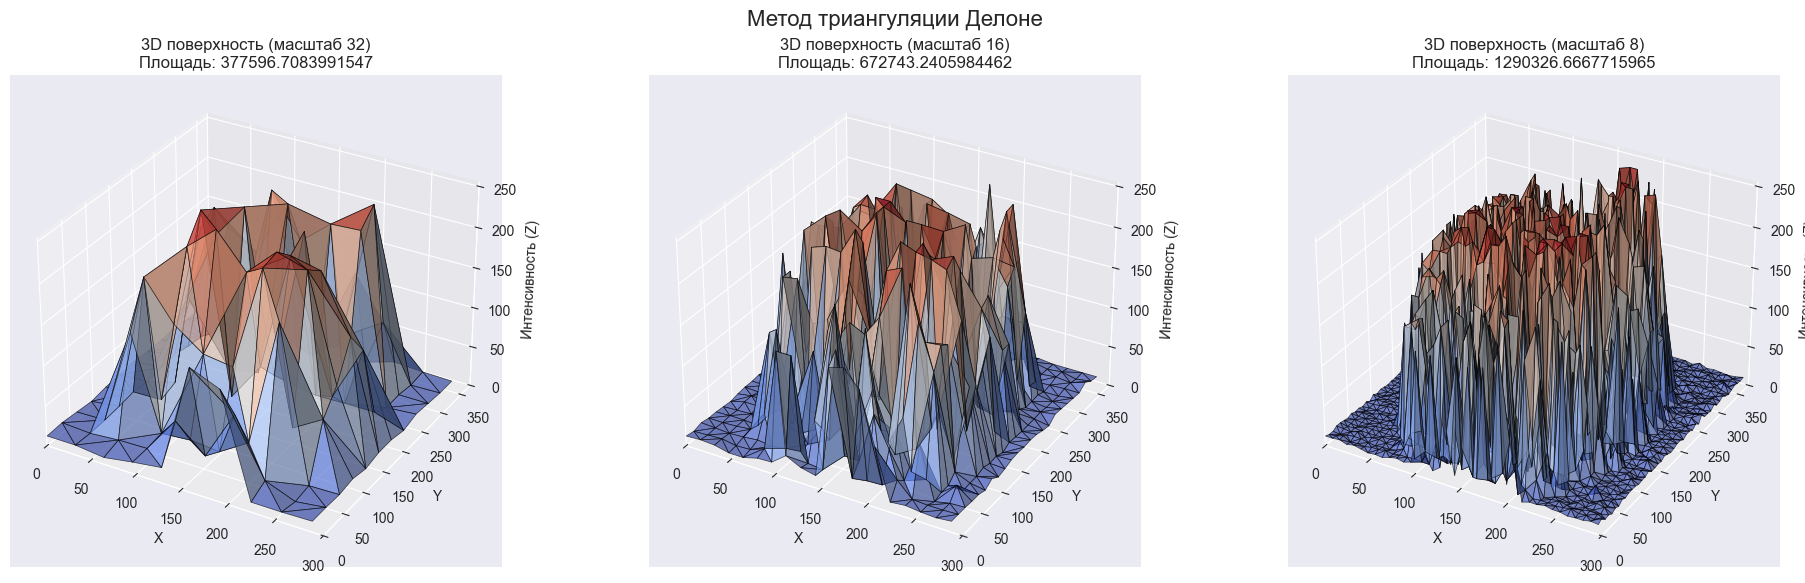


=== Сравнение результатов ===
'Метод' | 'Фрактальная размерность'
--------------------------------------------------
'Метод квадратов' | 1.6821378382208516
'Метод кубов' | 2.6129427593181056
'Метод триангуляции' | 2.7949845132502156


In [7]:
def visualize_box_counting(image: np.ndarray, threshold: float = 0.9) -> float:
    """
    Визуализирует процесс расчета фрактальной размерности методом квадратов.

    Параметры:
    - image: 2D-массив (изображение), значения от 0 до 1.
    - threshold: Порог для бинаризации.
    """
    # Бинаризация изображения
    image = cv2.GaussianBlur(image, (1, 1), 0)
    image = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 21
    ) / 255
    binary_image = image < threshold

    # Рассчитываем фрактальную размерность
    fractal_dim = fractal_dimension_boxes(image, threshold)
    print(f"Фрактальная размерность (метод квадратов): {fractal_dim:}")

    # Размеры квадратов для визуализации
    sizes = [75, 30, 15, 5]
    xmin, xmax = 0, image.shape[1]
    ymin, ymax = 0, image.shape[0]

    # Создаем фигуру для визуализации
    fig, axes = plt.subplots(1, len(sizes), figsize=(16, 4))
    fig.suptitle("Метод квадратов (Box Counting)", fontsize=16)

    for i, size in enumerate(sizes):
        ax = axes[i]
        ax.imshow(image, cmap="gray", vmin=0, vmax=1,
                  extent=[xmin, xmax, ymin, ymax], origin="upper")

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Размер ячейки: {size}x{size}")

        # Добавляем квадраты, которые частично содержат объект
        count = 0
        for y in range(image.shape[0] // size + 1):
            for x in range(image.shape[1] // size + 1):
                # Вычисляем границы текущего квадрата
                y_start = y * size
                y_end = min((y + 1) * size, image.shape[0])
                x_start = x * size
                x_end = min((x + 1) * size, image.shape[1])

                # Проверяем содержимое квадрата
                box = binary_image[y_start:y_end, x_start:x_end]
                if np.any(box) and not np.all(box):
                    count += 1
                    rect = patches.Rectangle(
                        (x_start, image.shape[0] - y_end),
                        width=x_end - x_start,
                        height=y_end - y_start,
                        linewidth=1,
                        edgecolor="blue",
                        facecolor="red",
                        alpha=0.3)
                    ax.add_patch(rect)

        ax.text(0.5, 0.03, f"Найдено квадратов: {count}",
                transform=ax.transAxes,
                horizontalalignment="center",
                color="blue",
                fontsize=10,
                bbox=dict(facecolor="white", alpha=0.7))

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

    fig.savefig("images/box_counting_visualization.png", dpi=150, bbox_inches="tight")

    return fractal_dim


def visualize_log_plot_boxes(image: np.ndarray, threshold: float = 0.9) -> float:
    """
    Визуализирует логарифмический график для вычисления фрактальной размерности методом квадратов
    и показывает процесс линейной регрессии.

    Параметры:
    - image: 2D-массив (изображение), значения от 0 до 255
    - threshold: Порог для бинаризации

    Возвращает:
    - Фрактальную размерность
    """
    # Бинаризация изображения (как в вашем исходном коде)
    blurred = cv2.GaussianBlur(image, (1, 1), 0)
    binary_image = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 21
    ) / 255
    binary_image = binary_image < threshold  # Инвертируем если нужно

    # Определение максимально возможного размера квадрата (степень двойки)
    min_side = min(binary_image.shape)
    max_power = int(np.floor(np.log2(min_side)))
    box_sizes = 2 ** np.arange(max_power, 1, -1)  # например: [64, 32, 16, 8, 4, 2]

    # Считаем N(box_size) для каждого размера
    box_counts = []
    for size in box_sizes:
        count = count_nontrivial_boxes(binary_image, size)
        box_counts.append(count)
        print(f"Размер ячейки: {size}×{size}, Количество непустых ячеек: {count}")

    # Вычисляем логарифмы для линейной регрессии
    log_sizes = np.log(box_sizes)
    log_counts = np.log(box_counts)

    # Линейная регрессия: log(N) = -D * log(size) + C
    slope, intercept = np.polyfit(log_sizes, log_counts, 1)
    fractal_dim = -slope

    # Создаем массив с точками регрессионной прямой
    regression_line = intercept + slope * log_sizes

    # Создаем НОВУЮ фигуру с явным указанием всех осей
    # Это предотвратит смешивание с другими графиками в вашем коде
    fig = plt.figure(figsize=(10, 7))  # Даем уникальное имя фигуре

    # Создаем основную ось для графика
    ax_main = fig.add_subplot(111)

    # Строим точки измерений на этой конкретной оси
    ax_main.scatter(log_sizes, log_counts, color='blue', s=50, label='Измерения')

    # Строим линию регрессии на той же оси
    ax_main.plot(log_sizes, regression_line, color='red', linewidth=2,
                 label=f'Линейная регрессия: D = {fractal_dim:.4f}')

    # Добавляем формулу регрессии
    formula = f'ln(N) = {slope:.4f} × ln(ε) + {intercept:.4f}'
    ax_main.annotate(formula, xy=(0.05, 0.95), xycoords='axes fraction',
                     fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    # Настраиваем оси и подписи
    ax_main.set_xlabel('ln(ε) - логарифм размера ячейки', fontsize=12)
    ax_main.set_ylabel('ln(N(ε)) - логарифм количества ячеек', fontsize=12)
    ax_main.set_title('Определение фрактальной размерности методом квадратов', fontsize=14)
    ax_main.grid(True, alpha=0.3)
    ax_main.legend()

    # Добавляем текстовое пояснение на графике
    explanation = (
        f"Фрактальная размерность D = {fractal_dim:.4f}\n"
        f"Измеряется как наклон линии регрессии с обратным знаком\n"
        f"D = -slope = -({slope:.4f}) = {fractal_dim:.4f}"
    )
    ax_main.annotate(explanation, xy=(0.5, 0.15), xycoords='axes fraction',
                     fontsize=10, ha='center', bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    fig.savefig("images/fractal_dimension_log_plot.png", dpi=150, bbox_inches="tight")

    return fractal_dim


def visualize_cube_counting(image: np.ndarray) -> float:
    """
    Визуализирует процесс расчета фрактальной размерности методом кубов.

    Описание:
    Метод показывает как 3D-кубы покрывают "поверхность" изображения, где
    ось Z представляет интенсивность пикселей (оттенки серого от 0 до 255).

    Параметры:
    - image: 2D-массив (изображение), значения от 0 до 255.

    Возвращает:
    - Фрактальную размерность (вещественное число в интервале [2, 3]).
    """
    # Рассчитываем фрактальную размерность
    fractal_dim = fractal_dimension_cubes(image)
    print(f"Фрактальная размерность (метод кубов): {fractal_dim}")

    # Выбираем размеры кубов для визуализации
    cube_sizes = [32, 16, 8]

    # Создаем цветовую карту для кубов от синего (0) до красного (255)
    cmap = plt.cm.coolwarm

    # Создаем 3D фигуру для визуализации
    fig = plt.figure(figsize=(18, 6))
    fig.suptitle("Метод кубов (3D Box Counting)", fontsize=16)

    # Словарь для хранения количества кубов для каждого размера
    cube_counts = {}

    for i, size in enumerate(cube_sizes):
        # Создаем 3D подграфик
        ax = fig.add_subplot(1, len(cube_sizes), i + 1, projection='3d')

        height, width = image.shape
        max_height = np.max(image)

        # Количество кубов для текущего размера
        count = 0

        # Словарь для отслеживания уже отрисованных кубов
        drawn_cubes = {}

        # Перебираем все возможные позиции кубов
        for y in range(0, height, size):
            for x in range(0, width, size):
                patch = image[y:min(y + size, height), x:min(x + size, width)]
                if patch.size == 0:
                    continue

                local_min = np.min(patch)
                local_max = np.max(patch)

                # Кубы по оси Z, которые пересекаются с этим фрагментом
                z_start = int(local_min // size)
                z_end = int(np.ceil(local_max / size))

                if z_end > z_start:
                    # Добавляем кубы на график (не более 3 кубов по Z для наглядности)
                    for z in range(z_start, min(z_end, z_start + 3)):
                        # Вычисляем координаты куба
                        x_pos = x
                        y_pos = y
                        z_pos = 255 - z * size

                        # Определяем цвет куба на основе его Z-координаты (интенсивности)
                        # Нормализуем z_pos от 0 до 1 для цветовой карты
                        color_val = z_pos / 255
                        cube_color = cmap(color_val)

                        # Рисуем куб
                        cube_size = min(size, width - x, height - y)
                        if cube_size > 0:
                            # Создаем куб с цветом, зависящим от высоты
                            key = (x_pos, y_pos, z_pos)
                            if key not in drawn_cubes:  # Избегаем дублирования кубов
                                ax.bar3d(
                                    x_pos, y_pos, z_pos,
                                    cube_size, cube_size, size,
                                    color=cube_color, alpha=0.7, shade=True,
                                    edgecolor='black', linewidth=0.5
                                )
                                drawn_cubes[key] = True

                    # Увеличиваем счетчик кубов
                    count += (z_end - z_start)

        # Сохраняем количество кубов
        cube_counts[size] = count

        # Настройка подграфика
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Интенсивность (Z)')
        ax.set_title(f"Размер куба: {size}×{size}×{size}\nНайдено кубов: {count}")

        # Устанавливаем ограничения осей
        ax.set_xlim(0, width)
        ax.set_ylim(0, height)
        ax.set_zlim(0, max_height)

        # Добавляем оригинальное изображение как поверхность на дне
        x_grid, y_grid = np.meshgrid(np.arange(0, width, size), np.arange(0, height, size))
        z_grid = np.zeros_like(x_grid)
        img_sampled = image[::size, ::size]
        if x_grid.shape[0] > img_sampled.shape[0] or x_grid.shape[1] > img_sampled.shape[1]:
            # Обрезаем сетку, если она больше изображения
            x_grid = x_grid[:img_sampled.shape[0], :img_sampled.shape[1]]
            y_grid = y_grid[:img_sampled.shape[0], :img_sampled.shape[1]]
            z_grid = z_grid[:img_sampled.shape[0], :img_sampled.shape[1]]

        ax.plot_surface(
            x_grid, y_grid, z_grid,
            facecolors=plt.cm.gray(img_sampled / 255),
            alpha=0.5, shade=False
        )

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

    fig.savefig("images/cube_counting_visualization.png", dpi=150, bbox_inches="tight")

    return fractal_dim


def visualize_triangulation(image: np.ndarray) -> float:
    """
    Визуализирует процесс расчета фрактальной размерности методом триангуляции.

    Описание:
    Метод показывает как триангуляция Делоне используется для аппроксимации поверхности
    изображения, где интенсивность пикселей представляет высоту (ось Z) в 3D-пространстве.

    Параметры:
    - image: 2D-массив (изображение), значения от 0 до 255.

    Возвращает:
    - Фрактальную размерность (вещественное число в интервале [2, 3]).
    """
    # Рассчитываем фрактальную размерность
    fractal_dim = fractal_dimension_triangulation(image)
    print(f"Фрактальная размерность (метод триангуляции): {fractal_dim:}")

    # Масштабы для визуализации
    scales = [32, 16, 8]

    # Создаем цветовую карту от синего к красному
    cmap = plt.cm.coolwarm

    # Создаем фигуру для визуализации
    fig = plt.figure(figsize=(18, 6))
    fig.suptitle("Метод триангуляции Делоне", fontsize=16)

    # Словарь для хранения общей площади поверхности для каждого масштаба
    areas = {}

    for i, scale in enumerate(scales):
        # Создаем подграфик для 3D представления
        ax_3d = fig.add_subplot(1, len(scales), i + 1, projection='3d')

        height, width = image.shape

        # Выбираем точки из изображения с шагом scale
        y_coords, x_coords = np.mgrid[0:height:scale, 0:width:scale]
        points_2d = np.c_[x_coords.flatten(), y_coords.flatten()]

        # Проверяем, что у нас достаточно точек для триангуляции
        if len(points_2d) < 4:
            ax_3d.set_title(f"Масштаб {scale}: недостаточно точек")
            continue

        # Создаем 3D точки, добавляя интенсивность как z-координату
        z_coords = np.array([image[y, x] for y, x in zip(y_coords.flatten(), x_coords.flatten())])
        points_3d = np.c_[points_2d, z_coords]

        try:
            # Строим триангуляцию Делоне в 2D (по x и y координатам)
            tri = Delaunay(points_2d)

            # Вычисляем общую площадь поверхности в 3D
            total_area = 0

            # Нормализуем интенсивность для цветовой карты
            plt.Normalize(0, 255)

            # 3D представление с цветовым кодированием
            for simplex in tri.simplices:
                # Берем 3D координаты точек для каждого треугольника
                p1 = points_3d[simplex[0]]
                p2 = points_3d[simplex[1]]
                p3 = points_3d[simplex[2]]

                # Вычисляем площадь треугольника в 3D пространстве
                area = triangle_area_3d(p1, p2, p3)
                total_area += area

                # Вычисляем среднюю интенсивность (Z-координату) для треугольника
                avg_z = (p1[2] + p2[2] + p3[2]) / 3

                # Определяем цвет на основе средней интенсивности
                color_val = 1 - (avg_z / 255)
                face_color = cmap(color_val)

                # Рисуем треугольник в 3D с цветом, зависящим от высоты
                triangle = np.array([p1, p2, p3])
                ax_3d.plot_trisurf(
                    triangle[:, 0], triangle[:, 1], 255 - triangle[:, 2],
                    color=face_color, alpha=0.7, edgecolor='black', linewidth=0.5
                )

            # Настройка 3D графика
            ax_3d.set_xlabel('X')
            ax_3d.set_ylabel('Y')
            ax_3d.set_zlabel('Интенсивность (Z)')
            ax_3d.set_title(f"3D поверхность (масштаб {scale})\nПлощадь: {total_area}")

            # Устанавливаем ограничения осей для лучшей визуализации
            ax_3d.set_xlim(0, width)
            ax_3d.set_ylim(0, height)
            ax_3d.set_zlim(0, 255)

            # Сохраняем площадь для данного масштаба
            areas[scale] = total_area

        except Exception as e:
            ax_3d.set_title(f"Ошибка при масштабе {scale}: {str(e)}")

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.show()

    fig.savefig("images/triangulation_visualization.png", dpi=150, bbox_inches="tight")

    return fractal_dim


def analyze_fractal_dimensions(image: np.ndarray, threshold: float = 0.9):
    """
    Выполняет анализ фрактальной размерности тремя методами и визуализирует результаты.

    Параметры:
    - image: 2D-массив (изображение), значения от 0 до 1.
    - threshold: Порог для бинаризации.
    """
    print("\n=== Анализ фрактальной размерности изображения ===\n")

    # Визуализируем исходное изображение
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap="gray")
    plt.title("Исходное изображение")
    plt.axis("off")
    plt.show()

    # Визуализируем и рассчитываем фрактальную размерность каждым методом
    print("\n1. Метод квадратов (Box counting)")
    fd_boxes = visualize_box_counting(image, threshold)
    visualize_log_plot_boxes(image, threshold)

    print("\n2. Метод кубов (3D Box counting)")
    fd_cubes = visualize_cube_counting(image)

    print("\n3. Метод триангуляции Делоне")
    fd_triangulation = visualize_triangulation(image)

    # Выводим сравнительную таблицу результатов
    print("\n=== Сравнение результатов ===")
    print("'Метод' | 'Фрактальная размерность'")
    print("-" * 50)
    print(f"'Метод квадратов' | {fd_boxes}")
    print(f"'Метод кубов' | {fd_cubes}")
    print(f"'Метод триангуляции' | {fd_triangulation}")


if show_graphic_analysis:
    analyze_fractal_dimensions(image, threshold=0.25)

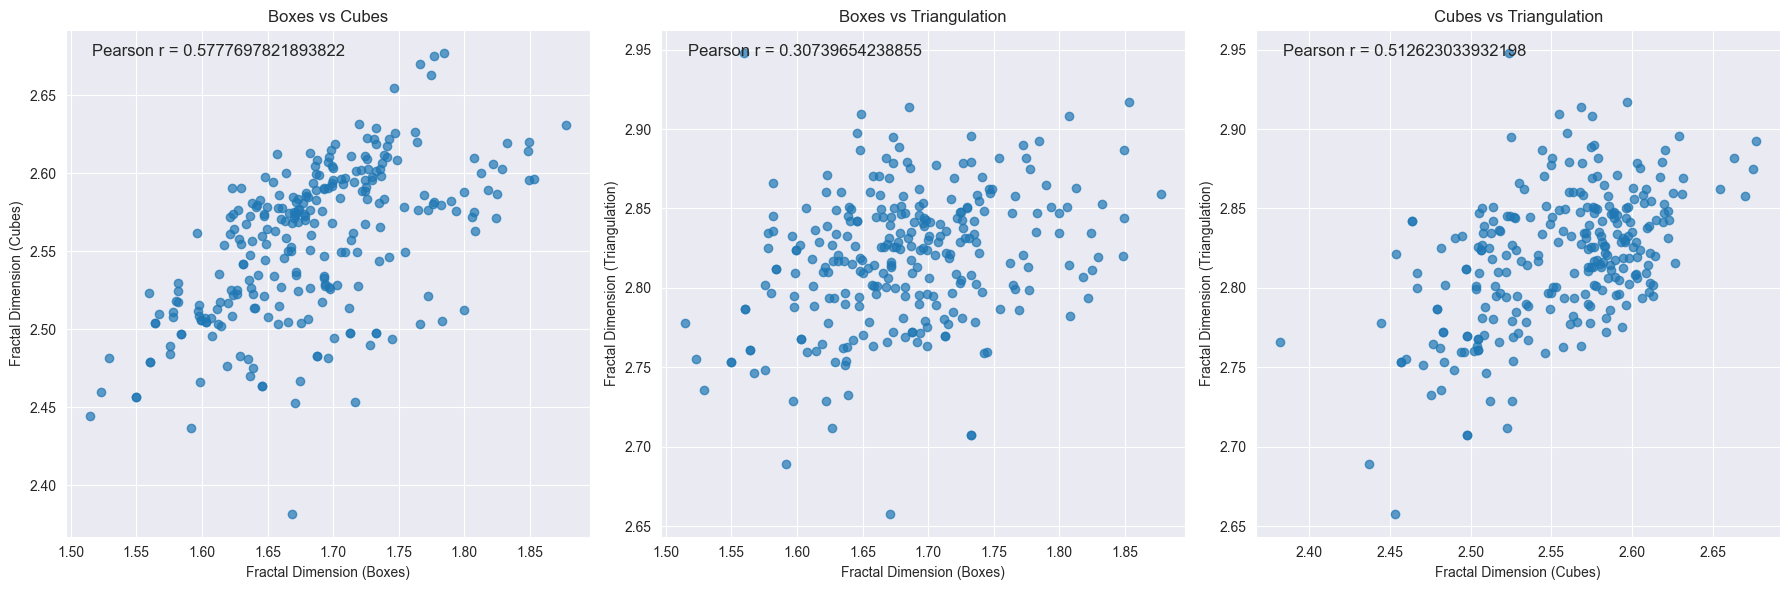

Коэффициенты корреляции Пирсона:
Boxes vs Cubes: 0.5777697821893822
Boxes vs Triangulation: 0.30739654238855
Cubes vs Triangulation: 0.512623033932198


In [8]:
# Построение диаграмм разброса и вычисление коэффициентов корреляции Пирсона
# r = (Σ (x_i - x̄)(y_i - ȳ)) / sqrt(Σ (x_i - x̄)² * Σ (y_i - ȳ)²)
# где x_i и y_i — значения фрактальных размерностей для каждой пары точек,
# x̄ и ȳ — их средние значения, а Σ означает суммирование по всем точкам.

plt.figure(figsize=(18, 6))

# Диаграмма 1: Boxes vs Cubes
plt.subplot(1, 3, 1)
plt.scatter(df["fractal_dimension_boxes"], df["fractal_dimension_cubes"], alpha=0.7)
plt.title("Boxes vs Cubes")
plt.xlabel("Fractal Dimension (Boxes)")
plt.ylabel("Fractal Dimension (Cubes)")
corr_boxes_cubes = df["fractal_dimension_boxes"].corr(df["fractal_dimension_cubes"], method="pearson")
plt.annotate(f"Pearson r = {corr_boxes_cubes:}", xy=(0.05, 0.95), xycoords="axes fraction", fontsize=12)

# Диаграмма 2: Boxes vs Triangulation
plt.subplot(1, 3, 2)
plt.scatter(df["fractal_dimension_boxes"], df["fractal_dimension_triangulation"], alpha=0.7)
plt.title("Boxes vs Triangulation")
plt.xlabel("Fractal Dimension (Boxes)")
plt.ylabel("Fractal Dimension (Triangulation)")
corr_boxes_tri = df["fractal_dimension_boxes"].corr(df["fractal_dimension_triangulation"], method="pearson")
plt.annotate(f"Pearson r = {corr_boxes_tri:}", xy=(0.05, 0.95), xycoords="axes fraction", fontsize=12)

# Диаграмма 3: Cubes vs Triangulation
plt.subplot(1, 3, 3)
plt.scatter(df["fractal_dimension_cubes"], df["fractal_dimension_triangulation"], alpha=0.7)
plt.title("Cubes vs Triangulation")
plt.xlabel("Fractal Dimension (Cubes)")
plt.ylabel("Fractal Dimension (Triangulation)")
corr_cubes_tri = df["fractal_dimension_cubes"].corr(df["fractal_dimension_triangulation"], method="pearson")
plt.annotate(f"Pearson r = {corr_cubes_tri:}", xy=(0.05, 0.95), xycoords="axes fraction", fontsize=12)

plt.tight_layout()
plt.savefig("images/scatter_plots.png")
plt.show()

print(f"Коэффициенты корреляции Пирсона:")
print(f"Boxes vs Cubes: {corr_boxes_cubes:}")
print(f"Boxes vs Triangulation: {corr_boxes_tri:}")
print(f"Cubes vs Triangulation: {corr_cubes_tri:}")

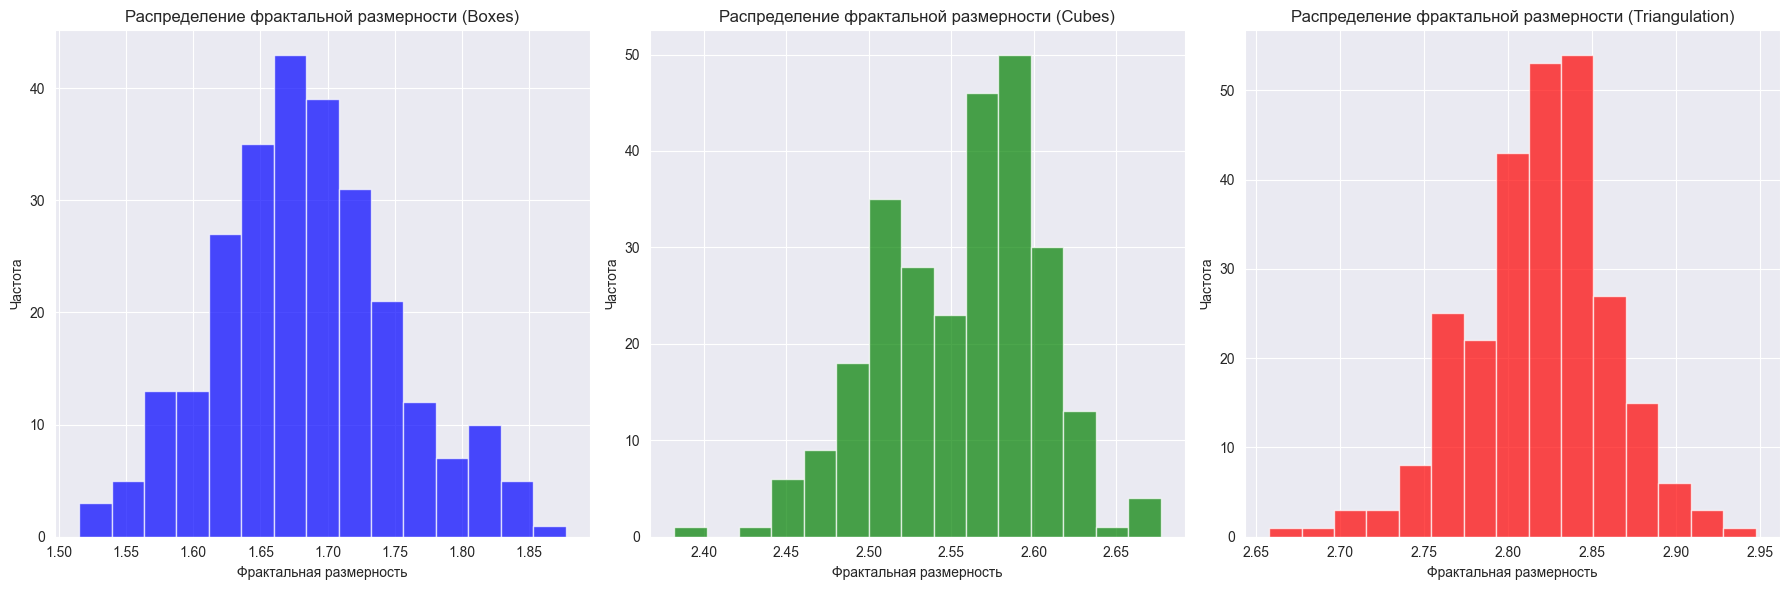

In [9]:
# Построение гистограмм распределения для всех трёх методов
plt.figure(figsize=(18, 6))

# Гистограмма для метода boxes
plt.subplot(1, 3, 1)
plt.hist(df["fractal_dimension_boxes"], bins=15, alpha=0.7, color="blue")
plt.title("Распределение фрактальной размерности (Boxes)")
plt.xlabel("Фрактальная размерность")
plt.ylabel("Частота")

# Гистограмма для метода cubes
plt.subplot(1, 3, 2)
plt.hist(df["fractal_dimension_cubes"], bins=15, alpha=0.7, color="green")
plt.title("Распределение фрактальной размерности (Cubes)")
plt.xlabel("Фрактальная размерность")
plt.ylabel("Частота")

# Гистограмма для метода triangulation
plt.subplot(1, 3, 3)
plt.hist(df["fractal_dimension_triangulation"], bins=15, alpha=0.7, color="red")
plt.title("Распределение фрактальной размерности (Triangulation)")
plt.xlabel("Фрактальная размерность")
plt.ylabel("Частота")

plt.tight_layout()
plt.savefig("images/histograms.png")
plt.show()

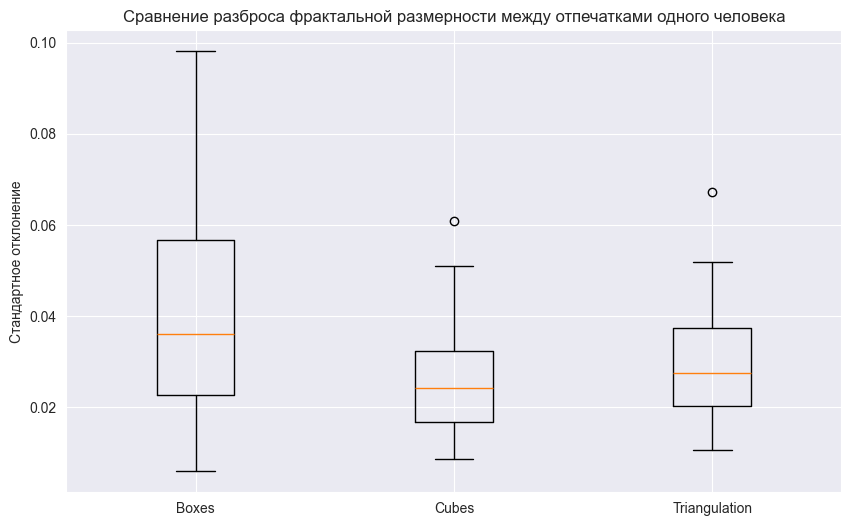

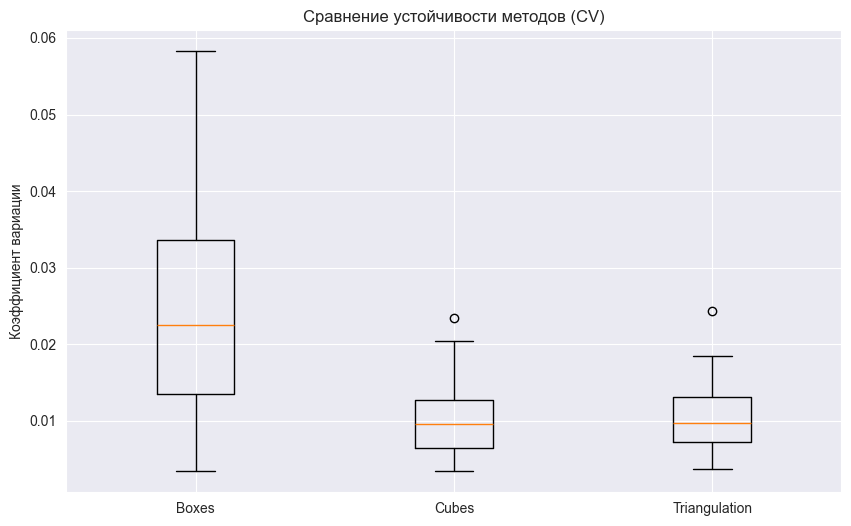

Boxes: Среднее σ = 0.03925269276357529, Средний CV = 0.02327535102355225
Cubes: Среднее σ = 0.0261213090404613, Средний CV = 0.01023126240015458
Triangulation: Среднее σ = 0.028871658773803217, Средний CV = 0.010245636096801644


In [10]:
# Считаем среднее значение и стандартное отклонение по каждому человеку
# X̄ = (X₁ + X₂ + ... + Xn) / n
# σ = √[(Σ(Xi - X̄)²) / (n - 1)]

stats = df.groupby("person_id").agg({
    "fractal_dimension_boxes": ["mean", "std"],
    "fractal_dimension_cubes": ["mean", "std"],
    "fractal_dimension_triangulation": ["mean", "std"]
})

# Преобразование названия колонок в вид единой строки
# Пример: ("fractal_dimension_boxes", "mean") в "fractal_dimension_boxes_mean"
stats.columns = ['_'.join(col) for col in stats.columns]
stats = stats.reset_index()

# Добавим коэффициент вариации (CV = std / mean)
for method in ["boxes", "cubes", "triangulation"]:
    stats[f"cv_{method}"] = stats[f"fractal_dimension_{method}_std"] / stats[f"fractal_dimension_{method}_mean"]

# -------- Визуализация: boxplot -------- #
plt.figure(figsize=(10, 6))
plt.boxplot([
    stats["fractal_dimension_boxes_std"],
    stats["fractal_dimension_cubes_std"],
    stats["fractal_dimension_triangulation_std"]
], tick_labels=["Boxes", "Cubes", "Triangulation"])
plt.ylabel("Стандартное отклонение")
plt.title("Сравнение разброса фрактальной размерности между отпечатками одного человека")
plt.grid(True)
plt.savefig("images/std_per_method_boxplot.png")
plt.show()

# -------- Визуализация: коэффициент вариации -------- #
plt.figure(figsize=(10, 6))
plt.boxplot([
    stats["cv_boxes"],
    stats["cv_cubes"],
    stats["cv_triangulation"]
], tick_labels=["Boxes", "Cubes", "Triangulation"])
plt.ylabel("Коэффициент вариации")
plt.title("Сравнение устойчивости методов (CV)")
plt.grid(True)
plt.savefig("images/cv_per_method_boxplot.png")
plt.show()

# -------- Вывод общих результатов -------- #
for method in ["boxes", "cubes", "triangulation"]:
    mean_std = stats[f"fractal_dimension_{method}_std"].mean()
    mean_cv = stats[f"cv_{method}"].mean()
    print(f"{method.capitalize()}: Среднее σ = {mean_std}, Средний CV = {mean_cv}")

**Диаграмма размаха (boxplot)** - показывает распределение стандартных отклонений для каждого метода фрактальной размерности. На графике:
- **Медиана (среднее значение)** будет отмечена линией внутри коробки.
- **Ящики** показывают диапазон, в котором находятся 50% значений (между 25-м и 75-м перцентилем).
- **Усы** показывают диапазон значений, которые не считаются выбросами.
- **Выбросы** (точки за пределами усов) показывают аномально высокие или низкие значения.

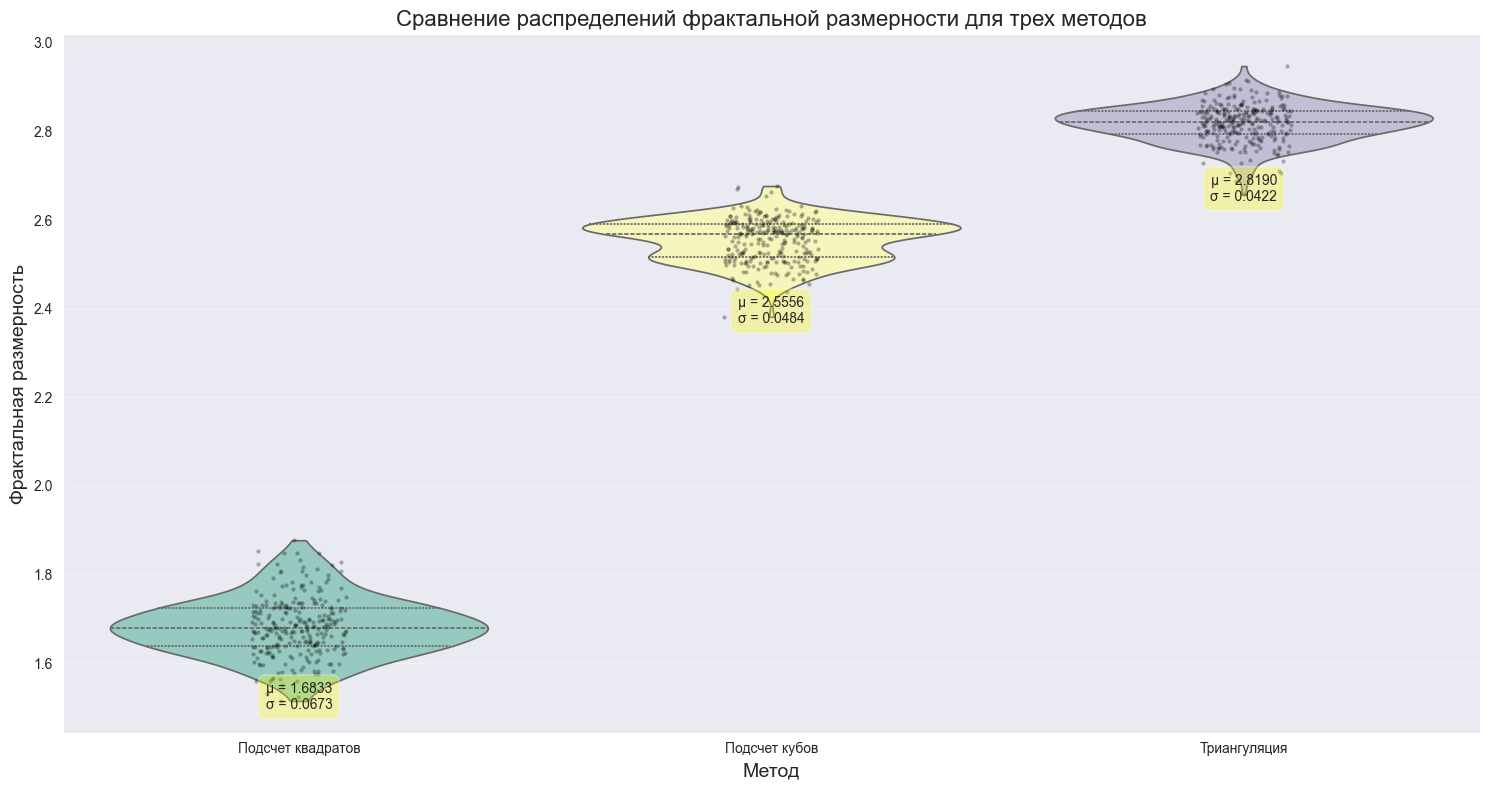

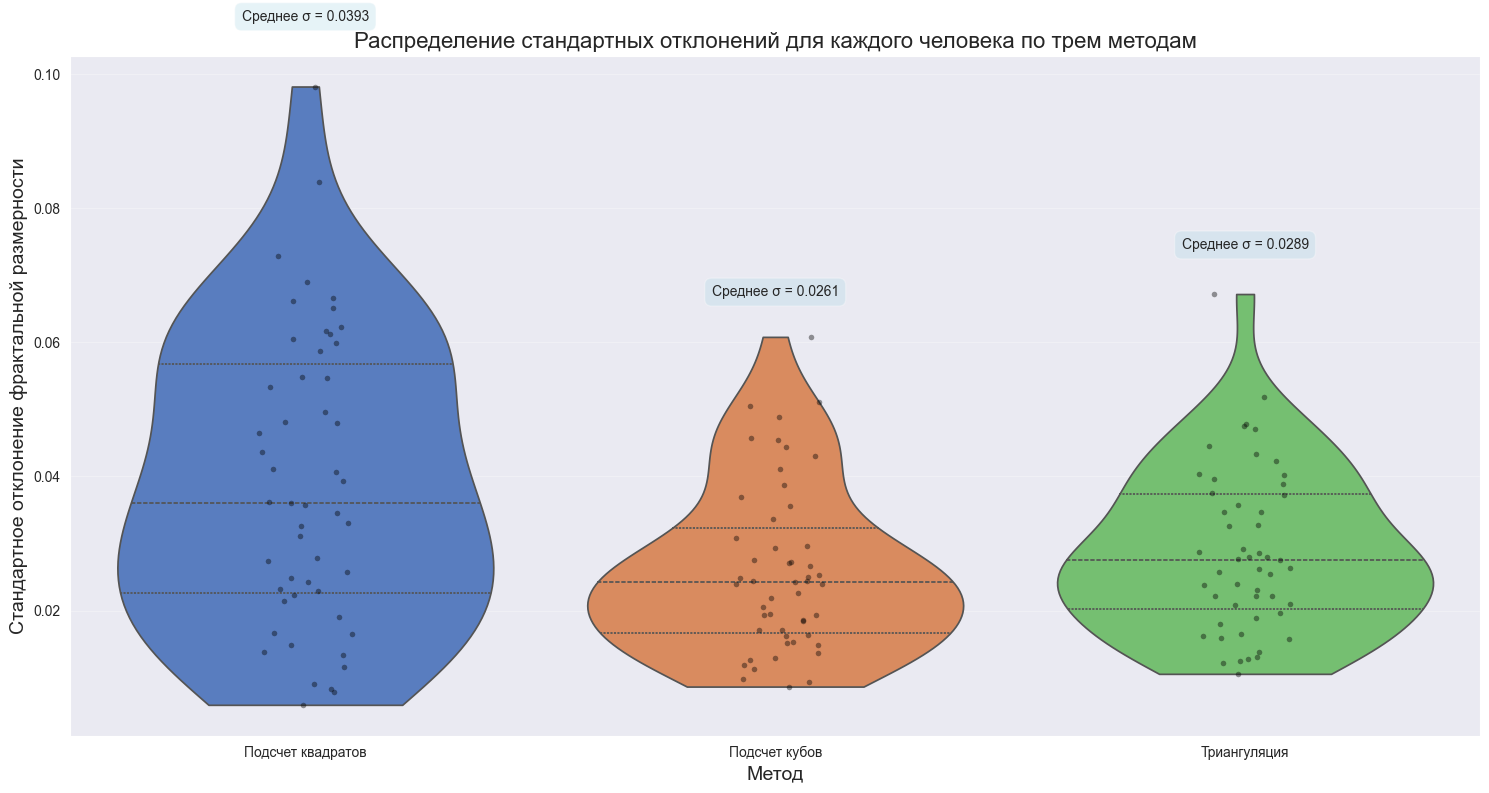

In [11]:
def create_violin_plots_for_fractal_methods(df: pd.DataFrame):
    """
    Создает скрипичные диаграммы для сравнения распределений фрактальной размерности
    для трех методов: подсчета квадратов, кубов и триангуляции.

    Параметры:
    - df: pd.DataFrame - датафрейм с расчетными значениями фрактальной размерности
    """
    # Создаем tidy-формат данных для seaborn
    plot_data = pd.DataFrame({
        'Метод': ['Подсчет квадратов'] * len(df) + ['Подсчет кубов'] * len(df) + ['Триангуляция'] * len(df),
        'Фрактальная размерность': list(df['fractal_dimension_boxes']) +
                                  list(df['fractal_dimension_cubes']) +
                                  list(df['fractal_dimension_triangulation']),
        'ID человека': list(df['person_id']) * 3
    })

    # Создаем фигуру соответствующего размера
    plt.figure(figsize=(15, 8))

    sns.violinplot(
        x='Метод',
        y='Фрактальная размерность',
        hue='Метод',
        data=plot_data,
        inner='quartile',  # отображаем квартили внутри
        palette='Set3',    # используем цветовую палитру Set3
        cut=0,             # обрезаем по минимальным и максимальным значениям
        legend=False       # Отключаем легенду, так как она дублирует ось X
    )

    # Добавляем точки для визуализации исходных данных
    sns.stripplot(
        x='Метод',
        y='Фрактальная размерность',
        data=plot_data,
        size=3,           # размер точек
        color='black',    # цвет точек
        alpha=0.3,        # прозрачность точек
        jitter=True       # добавляем разброс по оси X для лучшей визуализации
    )

    # Настройка графика
    plt.title('Сравнение распределений фрактальной размерности для трех методов', fontsize=16)
    plt.xlabel('Метод', fontsize=14)
    plt.ylabel('Фрактальная размерность', fontsize=14)
    plt.grid(axis='y', alpha=0.3)

    # Добавляем аннотации со статистическими характеристиками
    for i, method in enumerate(['boxes', 'cubes', 'triangulation']):
        col = f'fractal_dimension_{method}'
        mean_val = df[col].mean()
        std_val = df[col].std()

        # Добавляем аннотацию с информацией о среднем и стандартном отклонении
        plt.annotate(
            f'μ = {mean_val:.4f}\nσ = {std_val:.4f}',
            xy=(i, df[col].min()),  # позиция аннотации
            xytext=(i, df[col].min() - 0.05 * (df[col].max() - df[col].min())),
            ha='center',            # выравнивание по центру
            fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3)  # обрамление
        )

    plt.tight_layout()
    plt.savefig('images/fractal_methods_violin_plot.png', dpi=150, bbox_inches='tight')
    plt.show()


def create_std_violin_plots(stats: pd.DataFrame):
    """
    Создает скрипичные диаграммы стандартных отклонений фрактальной размерности
    для каждого человека по трем методам.

    Параметры:
    - stats: pd.DataFrame - датафрейм со статистикой по каждому человеку
    """
    # Готовим данные
    std_data = pd.DataFrame({
        'Метод': ['Подсчет квадратов'] * len(stats) + ['Подсчет кубов'] * len(stats) + ['Триангуляция'] * len(stats),
        'Стандартное отклонение': list(stats['fractal_dimension_boxes_std']) +
                                   list(stats['fractal_dimension_cubes_std']) +
                                   list(stats['fractal_dimension_triangulation_std']),
        'ID человека': list(stats['person_id']) * 3
    })

    # Создаем фигуру
    plt.figure(figsize=(15, 8))

    # Строим скрипичную диаграмму
    sns.violinplot(
        x='Метод',
        y='Стандартное отклонение',
        hue='Метод',  # Добавляем hue
        data=std_data,
        inner='quartile',
        palette='muted',
        cut=0,
        legend=False    # Отключаем легенду
    )

    # Отображаем точки данных
    sns.stripplot(
        x='Метод',
        y='Стандартное отклонение',
        data=std_data,
        size=4,
        color='black',
        alpha=0.4,
        jitter=True
    )

    # Настройка графика
    plt.title('Распределение стандартных отклонений для каждого человека по трем методам', fontsize=16)
    plt.xlabel('Метод', fontsize=14)
    plt.ylabel('Стандартное отклонение фрактальной размерности', fontsize=14)
    plt.grid(axis='y', alpha=0.3)

    # Аннотации со средними значениями
    for i, method in enumerate(['boxes', 'cubes', 'triangulation']):
        col = f'fractal_dimension_{method}_std'
        mean_std = stats[col].mean()

        plt.annotate(
            f'Среднее σ = {mean_std:.4f}',
            xy=(i, stats[col].max()),
            xytext=(i, stats[col].max() + 0.1 * stats[col].max()),
            ha='center',
            fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.3)
        )

    plt.tight_layout()
    plt.savefig('images/std_per_person_violin_plot.png', dpi=150, bbox_inches='tight')
    plt.show()


create_violin_plots_for_fractal_methods(df)

# Расчет статистики по каждому человеку
stats = df.groupby("person_id").agg({
    "fractal_dimension_boxes": ["mean", "std"],
    "fractal_dimension_cubes": ["mean", "std"],
    "fractal_dimension_triangulation": ["mean", "std"]
})

# Преобразование названия колонок
stats.columns = ['_'.join(col) for col in stats.columns]
stats = stats.reset_index()

create_std_violin_plots(stats)

Каждая **"скрипка"** состоит из зеркально отраженного графика плотности вероятности, который показывает частоту встречаемости определенных значений в наборе данных. Горизонтальные пунктирные линии внутри "скрипки" указывают на квартили (25%, 50%, 75%). Точки представляют индивидуальные измерения